In [ ]:
from torchvision import datasets 
data_path = './datasets/'
cifar10 = datasets.CIFAR10(root = data_path, download=True, train=True)
difar10_val = datasets.CIFAR10(root = data_path, download=True, train=False)

In [2]:
# Print the method resolution order of our dataset instance. 
# Notice that the dataset is returned as a subclass of torch.utils.data.dataset.Dataset base class. 
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [3]:
cifar10.__repr__()

'Dataset CIFAR10\n    Number of datapoints: 50000\n    Root location: ./datasets/\n    Split: Train'

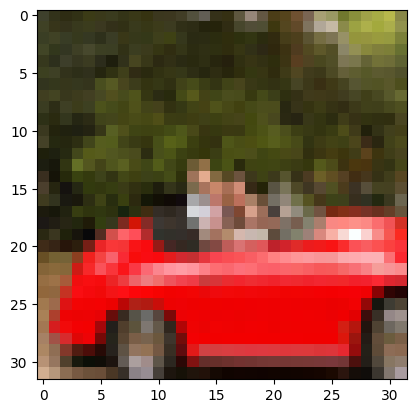

In [4]:
import matplotlib.pyplot as plt 

img, label = cifar10[99]
plt.imshow(img)
plt.show()

In [5]:
class_names = cifar10.classes
class_names[label]

'automobile'

Now let's use the `transforms` module from torchvision to convert these PIL images to PyTorch tensors. 

- This module defines a set of composable function-like objects that can be passed as an argument to a torchvision dataset upon instantiation, and they perform transformations on the data after it is loaded but before it is returned by `__getitem__`


In [7]:
from torchvision import transforms 
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [8]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

The image has been turned into a 3x32x32 tensor and therefore a 3-channel (RGB)

In [14]:
# instantiate the dataset with the transform 
tensor_cifar10 = datasets.CIFAR10(root=data_path, train=True, download=False, transform = transforms.ToTensor())

In [20]:
img_t, _ = tensor_cifar10[99]
type(img_t), type(img)

(torch.Tensor, PIL.Image.Image)

In [18]:
img_t.dtype, img_t.shape

(torch.float32, torch.Size([3, 32, 32]))

The `.ToTensor()` transform turns the data into a32-bit floating-point per channel, scaling the values down to the range `0.0` to `1.0`.

In [22]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

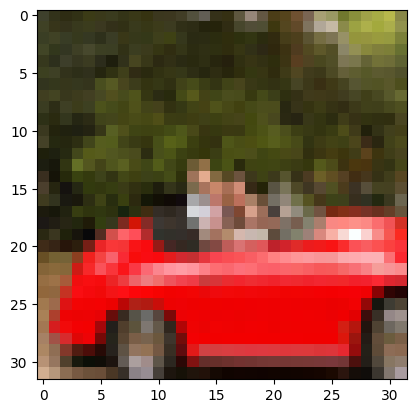

In [27]:
plt.imshow(img_t.permute(1,2,0))
plt.show()

Transforms can be chained using `transforms.Compose`. They can handle normalization and data augmentation transparently. 
- Each channel having zero mean and unitary standard deviation. 
- It is good practice to normalize the dataset so that each channel has zero mean and unitary standard deviation. 
    By choosing activation functions that are linear around `0` plus or minus `1`(or`2`), keeping the data in the same range means it's more likely that neurons have nonzero gradients and hence will learn sooner. 
- Also, Normalizing each channel so that it has the same distribution will ensure that channel information can be mixed and update through gradient descent using the same learning rate. 
- `transforms.Normalize` takes mean and stdev as arguments. 


In [38]:
tensor_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
# using transforms.Normalize, we can compute the mean value and the standard deviation of each channel across the dataset 
# then apply the following transform: v_n[c] = (v[c] - mean[c]) / stdev[c]
import torch 

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

`3` channels (RGB), with height `32`, width`32`, and `50000` of these (images). 

In [ ]:
imgs.view(3,-1).mean(dim=1), imgs.view(3,-1).std(dim=1)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [40]:
transforms.Normalize(mean = (0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [41]:
transformed_cifar10 = datasets.CIFAR10(
    root = data_path, 
    download=False, 
    train=True, 
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616)),
    ])
)

Plotting the normalized image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9802876..2.1264887].


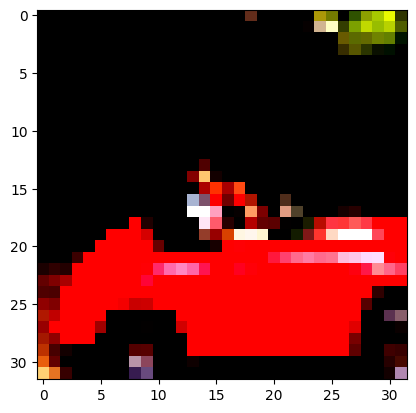

In [47]:
img_t, label = transformed_cifar10[99]
plt.imshow(img_t.permute(1,2,0))
plt.show()